In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# 1. Data Preprocessing
## 1.1 Import training set and test set

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test = pd.read_csv('/kaggle/input/titanic/test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 1.2 Examine Dataset
### 1.2.1 Analyze data type of each feature
#### Categorical: nominal, ordinal, ratio, or interval-based?
Features that contain Categorical data: Survived, Sex, Embarked

Features that contain Ordinal data: Pclass
#### Numerical: discrete, continuous, or time-series?
Features that contain Continuous data: Age, Fare

Features that contain Discrete data: SibSp, Parch

### 1.2.2 Find out if each feature contains null values
#### Most features do not have null values, except for 3 features that contain null values: Age, Cabin, Embarked. 
Cabin has a lot of(80%) missing values, might consider dropping this feature;

Age has some(20%) missing values, we need to fill N/A;

Embarked has very little(~0.2%) missing values, fill N/A;

In [4]:
train.info()
print('_'*45)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
_____________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pass

In [5]:
train_age_missing_ratio = '{:.2%}'.format((891-714)/819)
train_cabin_missing_ratio = '{:.2%}'.format((891-204)/819)
train_embarked_missing_ratio = '{:.2%}'.format((891-889)/819)
print('In training set:')
print('Cabin has',train_cabin_missing_ratio,'data points missing')
print('Age has',train_age_missing_ratio,'data points missing')
print('Embarked has',train_embarked_missing_ratio,'data points missing')

In training set:
Cabin has 83.88% data points missing
Age has 21.61% data points missing
Embarked has 0.24% data points missing


In [6]:
age_missing_ratio = '{:.2%}'.format((418-332)/418)
cabin_missing_ratio = '{:.2%}'.format((418-91)/418)
embarked_missing_ratio = '{:.2%}'.format((418-418)/418)
print('In test set:')
print('Cabin has',cabin_missing_ratio,'data points missing')
print('Age has',age_missing_ratio,'data points missing')
print('Embarked has',embarked_missing_ratio,'data points missing')

In test set:
Cabin has 78.23% data points missing
Age has 20.57% data points missing
Embarked has 0.00% data points missing


### 1.2.3 Evaluate representativeness of our training set data
#### Consider:
1. What's the ratio of training set data to the entire population? 

Answer: 40.06%. Thus we have decent amount of training data. Check.

2. Within training set, what's the survival rate comparing with population survival rate?

Answer: Training set survival rate = 38.38%, while population survival rate = 32.46%. Data is not skewed, check.

3. Within training set, what's the ratio of men and women? We want decent amount of data from both men and women.

Answer: 64.76% men, and 35.24% women. Check.

4. What's the distribution of passenger class within training set? We want training set to have decent amount of data across all PClasses.

Answer: class 3: 55.11%; class 2: 20.65%; class 1: 24.24%. Check.

5. What's the distribution of embarked class within training set? We want decent amount of data across all embarked gates too.

Answer: S: 72.28%; C: 18.86%. Q: 8.64%. Check.

6. What's the distribution of age within training set? We want every age group to be represented in training set.

Answer: Within training set: 25% of people are older than 38, 50% of people are 20-38, 25% of people younger than 20. Check.

7. What's the distribution of fare prices within training set? We want different fare price groups to be represented here.

Answer: Within training set: extremly high fare passengers are recorded, while plenty of data exist for low fare and medium fare passengers. 
#### Conclusion: The training set is representative of population.

In [7]:
print('Training set is','{:.2%}'.format(891/2224),'of entire passenger group\n')

print('A. Analysis of distribution of Categorical Data:\n')
print('   Survival rate within training set is','{:.2%}'.format(train.Survived.value_counts()[1]/train.shape[0]),'. Survival rate of entire passenger group is','{:.2%}'.format((2224-1502)/2224))
print('\n   Men represent','{:.2%}'.format((train.Sex.value_counts()[0])/train.shape[0]),'. Women represent','{:.2%}'.format(1-(train.Sex.value_counts()[0])/train.shape[0]),'.')
print('\n   Passenger class 3 has','{:.2%}'.format(train.Pclass.value_counts()[3]/train.shape[0]),'. Passenger class 2 has','{:.2%}'.format(train.Pclass.value_counts()[2]/train.shape[0]), '. Passenger class 1 has', '{:.2%}'.format(train.Pclass.value_counts()[1]/train.shape[0]),'.')
print('\n   Passengers that embarked from S = ','{:.2%}'.format(train.Embarked.value_counts()['S']/train.shape[0]),'. Passengers that embarked from C = ','{:.2%}'.format(train.Embarked.value_counts()['C']/train.shape[0]),'. Passengers that embarked from Q = ','{:.2%}'.format(train.Embarked.value_counts()['Q']/train.shape[0]))
print('\nB. Analysis of distribution of Numerical Data:')
print('\n   Age >=',(train.Age.describe()['75%']).round(0),': 25% of training set.','Age between',(train.Age.describe()['25%']).round(0),'and',(train.Age.describe()['75%']).round(0),': 50% of training set','. Age less than 20.0: 25% of training set.')
print('\n   Very few people paid extremly high price for tickets, while majority (75%) paid less than 31.')

Training set is 40.06% of entire passenger group

A. Analysis of distribution of Categorical Data:

   Survival rate within training set is 38.38% . Survival rate of entire passenger group is 32.46%

   Men represent 64.76% . Women represent 35.24% .

   Passenger class 3 has 55.11% . Passenger class 2 has 20.65% . Passenger class 1 has 24.24% .

   Passengers that embarked from S =  72.28% . Passengers that embarked from C =  18.86% . Passengers that embarked from Q =  8.64%

B. Analysis of distribution of Numerical Data:

   Age >= 38.0 : 25% of training set. Age between 20.0 and 38.0 : 50% of training set . Age less than 20.0: 25% of training set.

   Very few people paid extremly high price for tickets, while majority (75%) paid less than 31.


## 1.3 Feature Selection
### 1.3.1 Correlation Analysis of Categorical Features
We can test some correlation assumptions here: we suspect that passenger class, sex, SibSp, Parch and embarked are correlated with survival.
#### Pclass: more premium passenger class correlates with higher survival rate. Include Pclass as a feature.
#### Sex: women had significantly higher survival rate than men. Include Sex as a feature.
#### SibSp: In general, passengers with less siblings or spouses were more likley to survive, but we also witness when it's 0 survival rate is less than at 1/2. Consider creating a new feature by combining with Parch.
#### Parch: In general, passengers with less Parents or children on board were more likely to survive, but we also witness when it's 0 survival rate is less than at 1/2.
#### Emarked: passengers emarked at C had much higher survival rate, while passengers embarked at Q had 5% higher survival rate than passengers embarked at S. Include Embarked as a feature.

In [8]:
Pclass_analysis = train[['Pclass','Survived']].groupby(['Pclass']).mean().round(2).sort_values(by = 'Survived', ascending = False)
Sex_analysis = train[['Sex','Survived']].groupby(['Sex']).mean().round(2).sort_values(by = 'Survived', ascending = False)
Embarked_analysis = train[['Embarked','Survived']].groupby(['Embarked']).mean().round(2).sort_values(by = 'Survived', ascending = False)
SibSp_analysis = train[['SibSp','Survived']].groupby(['SibSp']).mean().round(2).sort_values(by = 'Survived', ascending = False)
Parch_analysis = train[['Parch','Survived']].groupby(['Parch']).mean().round(2).sort_values(by = 'Survived', ascending = False)
print(Pclass_analysis)
print('-'*20)
print(Sex_analysis)
print('-'*20)
print(Embarked_analysis)
print('-'*20)
print(SibSp_analysis)
print('-'*20)
print(Parch_analysis)

        Survived
Pclass          
1           0.63
2           0.47
3           0.24
--------------------
        Survived
Sex             
female      0.74
male        0.19
--------------------
          Survived
Embarked          
C             0.55
Q             0.39
S             0.34
--------------------
       Survived
SibSp          
1          0.54
2          0.46
0          0.35
3          0.25
4          0.17
5          0.00
8          0.00
--------------------
       Survived
Parch          
3          0.60
1          0.55
2          0.50
0          0.34
5          0.20
4          0.00
6          0.00


### 1.3.2 Correlation Analysis of Numerical Features
To understand correlations of numerical data with survival, a common approach is to visualize by plotting histograms.

We suspect that age and Fare should have correlations with survival rate.

#### Age: children and elder people were more likely to survive, quadratic correlation with survival rate. Include Age as a feature.
#### Fare: people that paid more for tickets have much higher chance of survival. Include Fare as a feature.

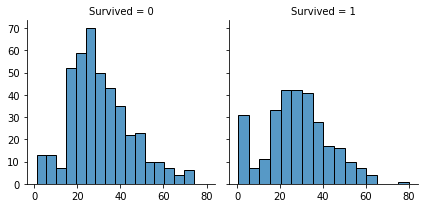

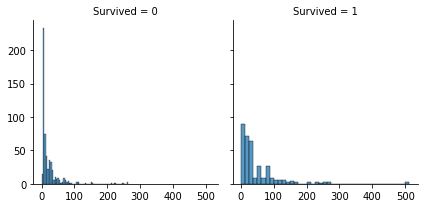

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

age_visualization = sns.FacetGrid(train, col = 'Survived')
age_visualization.map_dataframe(sns.histplot,x = 'Age')
fare_visualization = sns.FacetGrid(train, col = 'Survived')
fare_visualization.map_dataframe(sns.histplot,x = 'Fare')

### 1.3.3 Create New Features
Before dropping Name column, we suspect there's a correlation between title(Mr. Mrs., etc.) and survival. Therefore, try extract titles from Name column and test correlations.

In [10]:
merge = [train,test]
for i in merge:
    i['Title'] = i.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
for i in merge:
    i['Title'] = i['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    i['Title'] = i['Title'].replace('Mlle', 'Miss')
    i['Title'] = i['Title'].replace('Ms', 'Miss')
    i['Title'] = i['Title'].replace('Mme', 'Mrs')
    
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


Not let's look at SipSp and Parch. We want to create a new feature using these two features that has a clearer correlation with survival.

In [11]:
for i in merge:
    i['Family_size'] = i['SibSp']+i['Parch']+1
train[['Family_size','Survived']].groupby(['Family_size']).mean().sort_values(by = 'Survived', ascending = False)

,Survived
Family_size,
4,0.724138
3,0.578431
2,0.552795
7,0.333333
1,0.303538
5,0.200000
6,0.136364
8,0.000000
11,0.000000


In [12]:
for i in merge:
    i['Is_alone'] = 0
    i.loc[i['Family_size'] == 1, 'Is_alone'] = 1
train[['Is_alone','Survived']].groupby(['Is_alone']).mean().sort_values(by = 'Survived', ascending = False)

,Survived
Is_alone,
0,0.505650
1,0.303538


### 1.3.4 Drop Useless Features
We determined that Ticket, Cabin are useless features. Drop them.

In [13]:
for i in merge:
    i.drop(['Cabin','Ticket','Name','PassengerId','Family_size','SibSp','Parch'], axis = 1, inplace = True)

## 1.4 Feature Transformation
Now we have all the features we need. The final step before feeding into machine learning models is transformation of these features.
### 1.4.1 Title Transformation
We want to use one-hot-encoder here to transform this categorical data. Here we treat Mr as the dropped dummy variable.

In [14]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(train[['Title']]).toarray())
train = train.join(enc_df)
train.rename(columns = {0:'Master',1:'Miss',2:'Mr',3:'Mrs',4:'Rare'}, inplace = True)
train.drop(['Title','Mr'], axis = 1, inplace = True)
# test set
enc_df1 = pd.DataFrame(enc.fit_transform(test[['Title']]).toarray())
test = test.join(enc_df1)
test.rename(columns = {0:'Master',1:'Miss',2:'Mr',3:'Mrs',4:'Rare'}, inplace = True)
test.drop(['Title','Mr'], axis = 1, inplace = True)

### 1.4.2 Sex Transformation
Use one-hot-encoder here as well. Notice that we drop Female column because we treat female as the reference group.

In [15]:
# training set
encsex_df = pd.DataFrame(enc.fit_transform(train[['Sex']]).toarray())
train = train.join(encsex_df)
train.rename(columns = {0:'Female',1:'Male'}, inplace = True)
train = train.drop(['Sex','Female'], axis = 1)
train.head()
# test set
encsex_df1 = pd.DataFrame(enc.fit_transform(test[['Sex']]).toarray())
test = test.join(encsex_df1)
test.rename(columns = {0:'Female',1:'Male'}, inplace = True)
test = test.drop(['Sex','Female'], axis = 1)

### 1.4.3 Embarked Transformation
The first step is to fill the null values with mode within training set.

One-hot-encoder for this column too.

In [16]:
freq_embarked = train.Embarked.dropna().mode()[0]
train['Embarked'] = train['Embarked'].fillna(freq_embarked)
test['Embarked'] = test['Embarked'].fillna(freq_embarked)

In [17]:
# training set
encemb_df = pd.DataFrame(enc.fit_transform(train[['Embarked']]).toarray())
train = train.join(encemb_df)
train.rename(columns = {0:'Embarked_C',1:'Embarked_Q',2:'Embarked_S'}, inplace = True)
train = train.drop(['Embarked','Embarked_C'],axis = 1)
# test set
encemb_df1 = pd.DataFrame(enc.fit_transform(test[['Embarked']]).toarray())
test = test.join(encemb_df1)
test.rename(columns = {0:'Embarked_C',1:'Embarked_Q',2:'Embarked_S'}, inplace = True)
test = test.drop(['Embarked','Embarked_C'],axis = 1)

### 1.4.4 Fare Transformation
We first fill null values in test set

Then we convert fare into ordinal values

In [18]:
test['Fare'].fillna(test['Fare'].dropna().median(), inplace=True)

In [19]:
# quartiles
train['FareBand'] = pd.qcut(train['Fare'],4)
train.FareBand.value_counts()
# update merge
merge = [train,test]
for i in merge:
    i.loc[ i['Fare'] <= 7.91, 'Fare'] = 0
    i.loc[(i['Fare'] > 7.91) & (i['Fare'] <= 14.454), 'Fare'] = 1
    i.loc[(i['Fare'] > 14.454) & (i['Fare'] <= 31), 'Fare']   = 2
    i.loc[ i['Fare'] > 31, 'Fare'] = 3
    i['Fare'] = i['Fare'].astype(int)
train = train.drop(['FareBand'], axis=1)

### 1.4.5 Age Transformation
We first fill null values

Then we convert age into ordinal values

In [20]:
guess_ages = np.zeros((2,3))
merge = [train, test]
for dataset in merge:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Male'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Male == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train.head()

,Survived,Pclass,Age,Fare,Is_alone,Master,Miss,Mrs,Rare,Male,Embarked_Q,Embarked_S
0,0,3,22,0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1,1,38,3,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,3,26,1,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1,1,35,3,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,3,35,1,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [21]:
train['AgeBand'] = pd.cut(train['Age'], 5)
train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)
for i in merge:    
    i.loc[ i['Age'] <= 16, 'Age'] = 0
    i.loc[(i['Age'] > 16) & (i['Age'] <= 32), 'Age'] = 1
    i.loc[(i['Age'] > 32) & (i['Age'] <= 48), 'Age'] = 2
    i.loc[(i['Age'] > 48) & (i['Age'] <= 64), 'Age'] = 3
    i.loc[ i['Age'] > 64, 'Age']
train.head()
train = train.drop(['AgeBand'], axis = 1)

# 2. Fit into Model
## 2.1 Logistic Regression (without hyperparameter tuning or PCA)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]
x_train,x_test,y_train,y_test = train_test_split(X_train,Y_train,train_size = 0.8)
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg.score(x_test,y_test)

0.8268156424581006

# 3. Submit Prediction

In [23]:
test1 = pd.read_csv('/kaggle/input/titanic/test.csv')
pred_y = logreg.predict(test)
pred_y = pred_y.astype(int)
pred_df = pd.DataFrame({'PassengerId':test1['PassengerId'].array,'Survived':pred_y})
pred_df.shape

(418, 2)